# Experiments for Classification using synthetic datasets

In [1]:
#Utilities
import numpy as np 

def rademacher_variables(vec_size):
    if vec_size % 2 != 0:
        return("Error, vector size should be even.")
    s = np.random.binomial(1,0.5, vec_size)
    a = sum(s)
    while a.all() !=0:
        s = np.random.binomial(1,0.5, vec_size)
        s[s < 1] = -1
        a = sum(s)
    return(s)
    
def rademacher_bound(dim_x, dim_y, array_x, delta, train_error, array_Rademacher):
    bound = np.zeros([dim_x,dim_y])
    c =3*(np.sqrt(np.log(2/delta))/((array_x)))
    for i in range(0,dim_x):
        bound[i] = np.add(train_error[i], array_Rademacher[i])
        bound[i] = np.add(bound[i],c)
    return(bound)

def vc_dimension_classification(dim_x, dim_y, array_x, array_Rademacher):
    VC = np.zeros([dim_x,dim_y])
    c = array_x/(2*np.log(array_x))
    for i in range(0,dim_x):
        VC[i] = (array_Rademacher[i]**2)*c
    return(VC)

def VC_bound(dim_x, dim_y, array_x, train_error, array_VCdim, delta):
    VCbound = np.ones([dim_x,dim_y])
    a = np.log(array_x/array_VCdim)
    a = np.where(a > 0, a, 0)
    c = np.log(delta/4)
    eta = []
    for i in range(0,dim_x):
        eta = ((array_VCdim[i]*(a[i] +1)) - c)/array_x
        VCbound[i] = train_error[i] + ((eta/2)*(1 + np.sqrt(1+((4*train_error[i])/eta))))
    VCbound[np.isnan(VCbound)] = 0
    return(VCbound)

## Experiment 1:  Evaluating how train and test error varies with increasing training set size.

<br>Empirical train and test error: Missclassification rate
<br>Theoretical Bounds: Rademacher and VC Bounds for Classification

Hyperparameters: 
<br>Additive noise with std = 0.1
<br>Test Samples = 50
<br>Train Samples = [10,20,30,40,....,190]
<br>We run each sample size 100 times and take the average for calculating the empirical erros to reduce noise. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

n = range(10,200,10)
n_2 = range(0,100)
test_error = np.zeros([3,len(n)])
train_error = np.zeros([3,len(n)])
temp_test = np.zeros([3,len(n_2)])
temp_train = np.zeros([3,len(n_2)])
temp_L = np.zeros([3,len(n_2)])
Rad = np.zeros([3,len(n)])

n_test = 50
#Test set
X1, Y1 = make_circles(n_samples=n_test, noise= 0.1)
X2, Y2 = make_moons(n_samples= n_test, noise=0.1)
X3, Y3 = make_gaussian_quantiles(n_samples = n_test,n_features=2, n_classes=2)
X_test = np.vstack([[X1],[X2],[X3]])
Y_test = np.vstack([[Y1],[Y2],[Y3]])


for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - data generation
        X1, Y1 = make_circles(n_samples=value, noise= 0.1)
        X2, Y2 = make_moons(n_samples= value, noise=0.3)
        X3, Y3 = make_gaussian_quantiles(n_samples = value,n_features=2, n_classes=2)
        X_train = np.vstack([[X1],[X2],[X3]])
        Y_train = np.vstack([[Y1],[Y2],[Y3]])

        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #rademacher sigma
        s = rademacher_variables(Y_train[0].shape[0])
        
        for i in range(0,3,1):
            #Step 2: model fitting
            # Create Decision Tree classifer object
            clf = DecisionTreeClassifier(max_depth= 3, min_samples_split = int(0.2*value))

            #inserting train data in model for training
            clf.fit(X_train[i],Y_train[i])

            #predicting values for train/test data
            Y_pred_test[i] = clf.predict(X_test[i])
            Y_pred_train[i] = clf.predict(X_train[i])

            #computing misclassification error
            acc_test = clf.score(X_test[i], Y_test[i])
            temp_test[i,j] =  1-acc_test

            acc_train= clf.score(X_train[i], Y_train[i])
            temp_train[i,j] = 1-acc_train

            #Rademacher constant`
            scores = Y_train[i] != Y_pred_train[i]
            L = np.dot(s, scores)/len(Y_train[i])
            temp_L[i,j] = L
    
    test_error[:,counter] = np.mean(temp_test, axis = 1)
    train_error[:,counter] = np.mean(temp_train, axis = 1)
    Rad[:,counter] = np.amax(temp_L, axis = 1)  
    
#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(3, len(n), np.array(n), 0.1, train_error, Rad)
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_classification(3, len(n), np.array(n), Rad)
print("VC Dimension")
print(VCdim)
VCBound = VC_bound(3, len(n), np.array(n), train_error, VCdim, 0.1)
print("VC Bound")
print(VCBound)

Rademacher Constant
[[0.2        0.2        0.16666667 0.15       0.14       0.15
  0.11428571 0.0875     0.1        0.09       0.08181818 0.1
  0.07692308 0.07142857 0.11333333 0.08125    0.09411765 0.08333333
  0.1       ]
 [0.2        0.15       0.1        0.125      0.12       0.08333333
  0.1        0.05       0.08888889 0.08       0.07272727 0.06666667
  0.06153846 0.08571429 0.04666667 0.05625    0.05294118 0.05
  0.04736842]
 [0.1        0.1        0.06666667 0.075      0.1        0.1
  0.1        0.1        0.08888889 0.06       0.07272727 0.09166667
  0.06153846 0.07142857 0.06666667 0.0625     0.05294118 0.06111111
  0.05263158]]
Rademacher Bound
[[0.83724551 0.64762276 0.5337485  0.49831138 0.4682491  0.46170759
  0.4246065  0.38753069 0.40502728 0.39062455 0.37893141 0.39727046
  0.37271119 0.36473182 0.4069497  0.37207784 0.38507327 0.37790253
  0.39211818]
 [0.79424551 0.50212276 0.3627485  0.34531138 0.3242491  0.26270759
  0.27203507 0.21015569 0.24302728 0.22612455 0.

<Figure size 720x576 with 0 Axes>

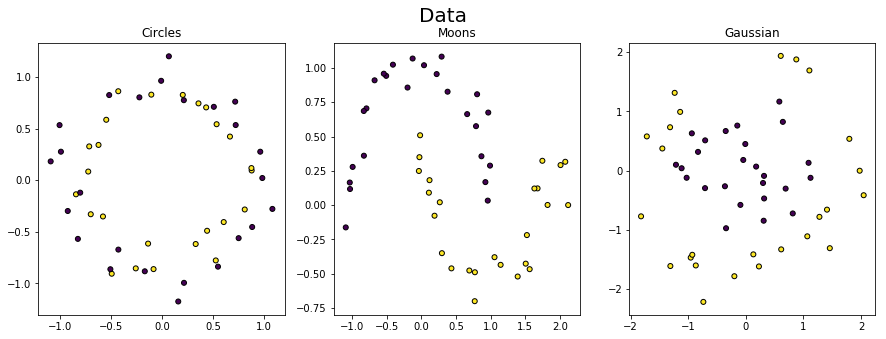

Test
[[0.4364 0.3926 0.366  0.3692 0.3692 0.362  0.3654 0.364  0.359  0.3676
  0.3612 0.3662 0.3632 0.363  0.3682 0.3628 0.3674 0.3592 0.3646]
 [0.2424 0.1662 0.1322 0.1258 0.1204 0.1134 0.114  0.1114 0.1046 0.106
  0.105  0.1052 0.1038 0.1046 0.1048 0.103  0.1042 0.103  0.1012]
 [0.3058 0.2336 0.2092 0.2024 0.1956 0.187  0.189  0.1914 0.1798 0.1836
  0.178  0.176  0.1718 0.1842 0.1818 0.1784 0.1746 0.187  0.18  ]]
Train
[[0.118      0.188      0.194      0.2185     0.2244     0.22516667
  0.23614286 0.235125   0.24733333 0.2487     0.24990909 0.254
  0.25584615 0.25621429 0.259      0.258375   0.26041176 0.26572222
  0.26478947]
 [0.075      0.0925     0.08966667 0.0905     0.1004     0.09283333
  0.09785714 0.09525    0.09644444 0.0942     0.09681818 0.09566667
  0.09384615 0.09821429 0.10053333 0.09925    0.09929412 0.09872222
  0.09884211]
 [0.014      0.0345     0.04766667 0.063      0.0646     0.06933333
  0.079      0.08625    0.08744444 0.0882     0.09309091 0.09408333
  0.0986

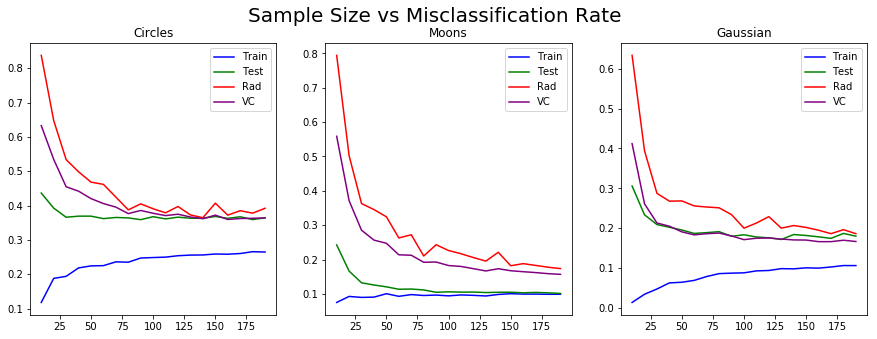

In [3]:
# Step 3: Evaluation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

funcs = ["Circles", "Moons", "Gaussian"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Data', fontsize=20)

for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].scatter(X_test[i][:, 0], X_test[i][:, 1], marker='o', c=Y_test[i], s=25, edgecolor='k')
plt.show()

print('Test')
print(test_error)
print("Train")
print(train_error)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Sample Size vs Misclassification Rate',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(n,train_error[i],color='blue', label = 'Train')
    axes[i].plot(n,test_error[i],color = 'green', label = 'Test')
    axes[i].plot(n,radBound[i], color = 'red', label = 'Rad')
    axes[i].plot(n,VCBound[i], color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

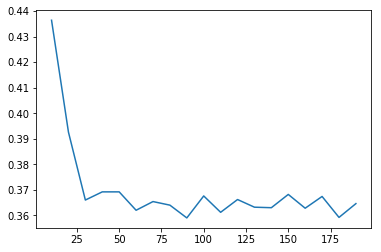

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    18.90      1.30448e+13        7          26.4068          27.8935     15.86s
   1    14.88      4.64221e+07       12          26.2552          29.4875     13.17s
   2    15.62      4.96957e+07       19            8.986          4.83213     11.92s
   3    14.65      2.56227e+07       24          6.59198          36.9405     10.94s
   4    11.60      3.66175e+06       30          4.35531          34.6586      8.64s
   5    14.17      5.98916e+06       30          2.53433          48.5554      6.85s
   6    15.62      1.26213e+07       11          2.73744          48.7878      5.66s
   7    10.16       1.4156e+07       14          2.67499          49.2251      3.31s
   8     7.70      8.95507e+06        7          2.66516          49.3923      1.77s
   9     7.18      1.78932e+06        7          2.66516          49.3923      0.00s
div(div(X0, -0.003), div(X0, -0.918))


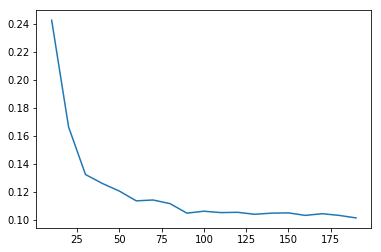

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    19.29      3.77004e+13       38          34.9037          11.2047     14.21s
   1    14.51       1.7709e+08       38          21.7225          123.245     11.82s
   2    11.27      3.99715e+07       46          21.0426          119.187     10.00s
   3    15.50      7.18884e+06       34          18.0032          160.913     10.68s
   4    25.16      9.63694e+06       50          12.9414          93.4922     10.97s
   5    33.93      2.30728e+07       51          11.1867          87.8646      9.97s
   6    33.00      5.66632e+07       24          10.2034          104.942      7.37s
   7    23.18      2.80604e+07       38          9.23914          75.5627      3.91s
   8    18.80      6.27528e+06       45          9.78875          75.2478      2.06s
   9    17.08      1.30693e+07       13          10.2069          150.214      0.00s
sqrt(mul(log(xexp(-0.312)), sqrt(add(sqrt(-0.799), xexp(div(X0, -0.906))))))


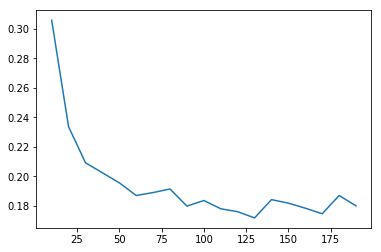

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    19.08      2.95011e+14       11          32.8628          58.4497     17.49s
   1    15.29       7.1469e+07       11          34.2308           46.822     14.25s
   2    13.03      6.89298e+09       11          27.4389          104.554     10.48s
   3    15.33       7.3095e+10       76          22.8003          33.8824     11.02s
   4    19.64      2.02461e+10       80          22.1513          39.4923      9.86s
   5    16.75      2.14869e+08       36          15.4926          13.6341      8.33s
   6    13.88      8.44966e+06       40          16.3035          4.18616      5.23s
   7    14.28      1.91398e+07       37          13.3329          72.0267      3.55s
   8    16.49       1.0182e+07       43          7.14207          84.0066      1.77s
   9    20.45      5.53798e+06       25          3.40892          7.28167      0.00s
mul(add(log(X0), add(div(mul(add(log(X0), 0.211), xexp(div(-0.921, 0.262))), add(X0, 0.895)), div(-0.478, 0.579))), xexp(div(-0.921, 0.262)))


In [6]:
#Step 4: Symbolic Regression (finding closed formula for test error depending only on sample size)
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_squared_error

# Create custom operations (exp) to be considered in the tree
def _xexp( x ):
    a = np.exp(-x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log','sqrt', xexp]
est_gp = SymbolicRegressor(population_size=3000,
                           generations=10, stopping_criteria=0.1,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.5, random_state=None,
                           function_set = f_set)


sample = []
for i in n: 
    sample.append(i)  
sample = np.array([sample])

for i in range(0,3):
    plt.plot(sample.reshape(-1,1),test_error[i])
    plt.show()
    est_gp.fit(sample.reshape(-1,1),1000*test_error[i])
    print(est_gp._program)



RMSE (test_error x symbolic regressor)
3.1654973166768956e-05
1.8689967823410095e-05
3.038968465513235e-05


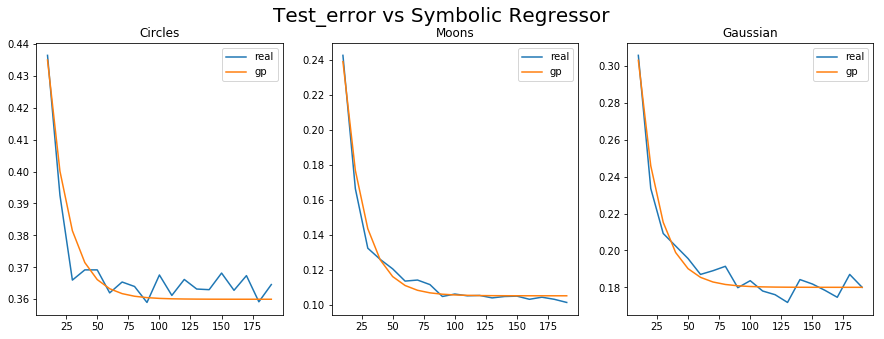

In [11]:
#Step 5: Evaluation for Symbolic Regressor

a1 = np.array([[0.14], [0.25], [0.23]])
a2 = np.array([[0.36], [0.105], [0.18]])

print("RMSE (test_error x symbolic regressor)")
y = np.zeros([3,sample.shape[1]])
for i in range(0,3):
    y[i] = ((np.sqrt(np.sqrt(np.sqrt(np.sqrt(np.exp(-sample))))))*a1[i])+a2[i]
    print(mean_squared_error(test_error[i], y[i].reshape(-1,1)))

funcs = ["Circles", "Moons", "Gaussian"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Test_error vs Symbolic Regressor',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(sample.reshape(-1,1),test_error[i], label = 'real')
    axes[i].plot(sample.reshape(-1,1),y[i].reshape(-1,1), label = 'gp')
    axes[i].legend(loc='upper right')
plt.show()

### Conclusions experiment 1: 
**Theoretical expectations for Empirical Error Estimation:**

Train and test error curves should coverge. (ok);
<br>Test error decreases as sample size increases until reaching irreducible error. (ok);
<br>Train error increases as samples size increases until reaching a value close to the irreducible error for test. (ok);
<br>Theoretical bounds should upper bound test error curve (ok);
<br>Observed: VC bound tighter than Rademacher bound for this experiment.

<br>**Symbolic Regression Results:**

Found a closed-form expression for test error when varying sample size which is common for all datasets:

$$ (c*\sqrt[16]{e^{-n}}+b) $$

<br>c and b are hyperpameters that should be set by the user. c controls the range in y-direction and b control the minimal height of the shape (usually the value of the irreducible error is a good value for b).
<br>MSE(empirical test error, symbolic regressor expression) < 10^-5 for all datasets. 

## Experiment 2:  Evaluating how train and test error varies with increasing model capacity
Empirical train and test error: Missclassification Rate
<br>Theoretical Bounds: Rademacher and VC Bounds for Classification

Hyperparameters: 
<br>Additive noise from normal distribution with std = 0.1/02
<br>Test Samples = 40
<br>Train Samples = 50
<br>Varying model capacity by tree depth size = [1,2,3...,29]
<br>Run each tree 100 times and take the average for calculating the empirical erros to reduce noise. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn import tree
from sklearn import metrics

samples = 40
d = range(1,30)
n_2 = range(0,100)
test_error = np.zeros([3,len(d)])
train_error = np.zeros([3,len(d)])
temp_test = np.zeros([3,len(n_2)])
temp_train = np.zeros([3,len(n_2)])
temp_L = np.zeros([3,len(n_2)])
Rad = np.zeros([3,len(d)])

n_test = 50
#Test set
X1, Y1 = make_circles(n_samples=n_test, noise= 0.1)
X2, Y2 = make_moons(n_samples= n_test, noise=0.2)
X3, Y3 = make_gaussian_quantiles(n_samples = n_test,n_features=2, n_classes=2)
X_test = np.vstack([[X1],[X2],[X3]])
Y_test = np.vstack([[Y1],[Y2],[Y3]])


for counter,value in enumerate(d): 
    for j in n_2:
        #step 1 - data generation
        X1, Y1 = make_circles(n_samples=samples, noise= 0.1)
        X2, Y2 = make_moons(n_samples= samples, noise=0.2)
        X3, Y3 = make_gaussian_quantiles(n_samples = samples,n_features=2, n_classes=2)
        X_train = np.vstack([[X1],[X2],[X3]])
        Y_train = np.vstack([[Y1],[Y2],[Y3]])  

        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #rademacher sigma
        s = rademacher_variables(int(Y_train[0].shape[0]))
        
        for i in range(0,3,1):
            #Step 2: model fitting
            # Create Decision Tree classifer object
            clf = DecisionTreeClassifier(max_depth= value)

            #inserting train data in model for training
            clf.fit(X_train[i],Y_train[i])

            #predicting values for train/test data
            Y_pred_test[i] = clf.predict(X_test[i])
            Y_pred_train[i] = clf.predict(X_train[i])

            #computing misclassification error
            acc_test = clf.score(X_test[i], Y_test[i])
            temp_test[i,j] =  1-acc_test

            acc_train= clf.score(X_train[i], Y_train[i])
            temp_train[i,j] = 1-acc_train

            #Rademacher constant`
            scores = Y_train[i] != Y_pred_train[i]
            L = np.dot(s, scores)/len(Y_train[i])
            temp_L[i,j] = L
    
    test_error[:,counter] = np.mean(temp_test, axis = 1)
    train_error[:,counter] = np.mean(temp_train, axis = 1)
    Rad[:,counter] = np.amax(temp_L, axis = 1)  
    
#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(3, len(d), (np.array(samples))*np.ones(len(d)), 0.1, train_error, Rad)
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_classification(3, len(d), (np.array(samples))*np.ones(len(d)), Rad)
print("VC Dimension")
print(VCdim)
VCBound = VC_bound(3, len(d), (np.array(samples))*np.ones(len(d)), train_error, VCdim, 0.1)
print("VC Bound")
print(VCBound)

Rademacher Constant
[[0.2   0.175 0.2   0.1   0.125 0.125 0.1   0.1   0.025 0.05  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.175 0.15  0.1   0.1   0.05  0.025 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.225 0.1   0.075 0.075 0.05  0.025 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]
Rademacher Bound
[[0.72031138 0.60481138 0.54506138 0.36131138 0.36531138 0.31131138
  0.25506138 0.24206138 0.15781138 0.18231138 0.12981138 0.12981138
  0.12981138 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138
  0.12981138 0.12981138 0.12981138 0.12981138 0.12981138 0.12981138
  0.12981138 0.12981138 0.12981138 0.12981138 0.12981138]
 [0.47081138 0.36656138 0.30456138 0.26781138 0.19306138 0.15681138
  0.12981138 0.12981138 0.12981138 0.12

c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply


<Figure size 720x576 with 0 Axes>

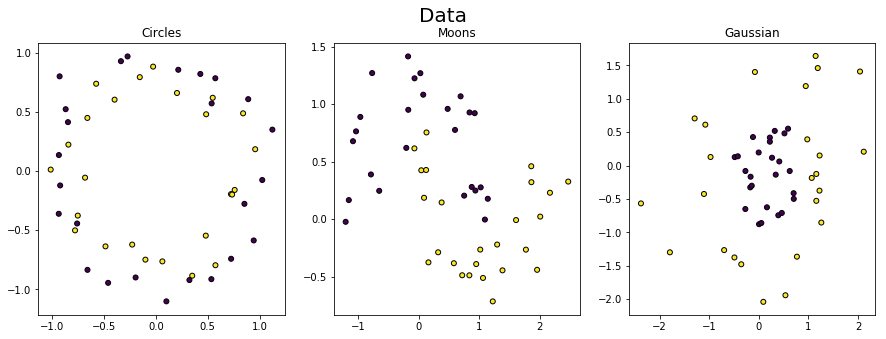

Test
[[0.4368 0.3848 0.327  0.29   0.2878 0.3016 0.306  0.2986 0.301  0.3112
  0.3022 0.3138 0.3028 0.3024 0.3024 0.2988 0.3086 0.2928 0.2948 0.3034
  0.3134 0.2848 0.3098 0.2966 0.2978 0.3066 0.2974 0.2936 0.3032]
 [0.2566 0.1632 0.1588 0.1646 0.1434 0.1354 0.1454 0.1294 0.1452 0.1338
  0.135  0.1332 0.1506 0.1362 0.1428 0.149  0.1502 0.1322 0.1324 0.1416
  0.133  0.1316 0.138  0.1324 0.1372 0.1402 0.1424 0.1466 0.1394]
 [0.3678 0.258  0.1632 0.1142 0.1298 0.1266 0.1178 0.1146 0.1256 0.1422
  0.128  0.1246 0.122  0.1424 0.1262 0.12   0.1374 0.1088 0.141  0.1296
  0.1202 0.1352 0.1276 0.1394 0.129  0.1316 0.1206 0.1344 0.1234]]
Train
[[3.9050e-01 3.0000e-01 2.1525e-01 1.3150e-01 1.1050e-01 5.6500e-02
  2.5250e-02 1.2250e-02 3.0000e-03 2.5000e-03 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.6600e-01 8.6750e-02 7.47

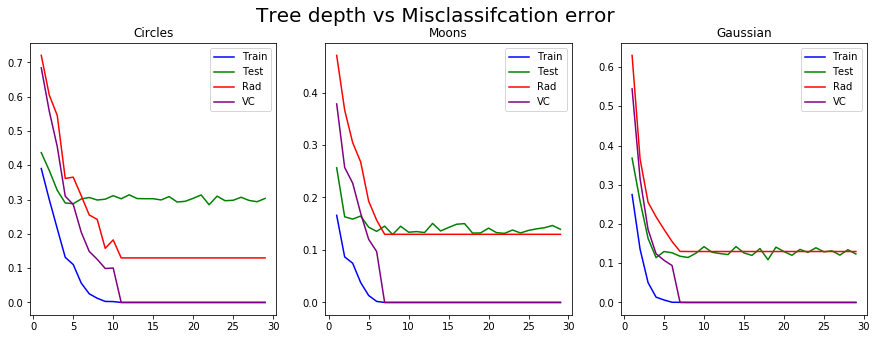

In [13]:
# Step 3: Evaluation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

funcs = ["Circles", "Moons", "Gaussian"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Data', fontsize=20)

for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].scatter(X_test[i][:, 0], X_test[i][:, 1], marker='o', c=Y_test[i], s=25, edgecolor='k')
plt.show()

print('Test')
print(test_error)
print("Train")
print(train_error)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Tree depth vs Misclassifcation error',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(d,train_error[i],color='blue', label = 'Train')
    axes[i].plot(d,test_error[i],color = 'green', label = 'Test')
    axes[i].plot(d,radBound[i], color = 'red', label = 'Rad')
    axes[i].plot(d,VCBound[i], color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[[0.4368 0.3848 0.327  0.29   0.2878 0.3016 0.306  0.2986 0.301  0.3112
  0.3022 0.3138 0.3028 0.3024 0.3024 0.2988 0.3086 0.2928 0.2948 0.3034
  0.3134 0.2848 0.3098 0.2966 0.2978 0.3066 0.2974 0.2936 0.3032]
 [0.2566 0.1632 0.1588 0.1646 0.1434 0.1354 0.1454 0.1294 0.1452 0.1338
  0.135  0.1332 0.1506 0.1362 0.1428 0.149  0.1502 0.1322 0.1324 0.1416
  0.133  0.1316 0.138  0.1324 0.1372 0.1402 0.1424 0.1466 0.1394]
 [0.3678 0.258  0.1632 0.1142 0.1298 0.1266 0.1178 0.1146 0.1256 0.1422
  0.128  0.1246 0.122  0.1424 0.1262 0.12   0.1374 0.1088 0.141  0.1296
  0.1202 0.1352 0.1276 0.1394 0.129  0.1316 0.1206 0.1344 0.1234]]


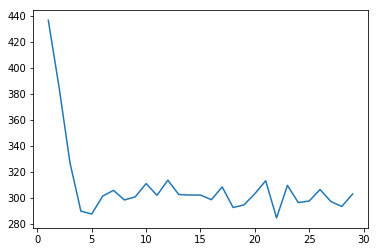

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:144: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    12.74      3.15878e+07       18          39.1125          24.2891     41.75s
   1     5.96      2.21468e+06       18          36.7462          44.7973     34.83s
   2     8.79      3.51914e+07       20          32.7073          51.9054     36.22s
   3     9.89      3.25543e+08       18           21.197          8.84794     40.22s
   4    12.30      4.06938e+08       21          9.90472          44.9064     40.88s
   5    15.36      3.34151e+08       19          9.03785          52.9564     40.73s
   6    14.37      1.03435e+08       18          6.71409          73.2832     36.70s
   7     8.76      6.26016e+06        9          8.94431           53.692     31.16s
   8     5.36      6.81422e+06        9          8.52308          57.3427     27.20s
   9     6.04      8.37143e+06        9          6.48462          75.0094     24.23s
  10     5.32      7.48927e+06        9          6.56154          74.3427     20.10s
  11     5.02       4.1347e+06        5           11.771         

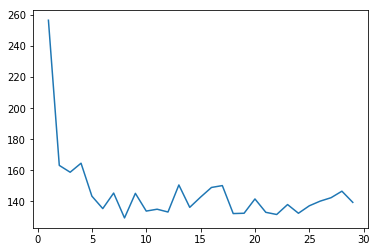

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:144: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    12.41      7.79436e+08       16          54.5016           55.025     45.08s
   1     4.68      6.31134e+06        9          29.8983          16.0932     35.94s
   2     5.55      8.66602e+06       13          17.3054          8.27528     33.40s
   3     5.96      9.34747e+06        6          11.8896          9.88036     32.67s
   4     5.65      8.86817e+06        6          8.12033           42.547     31.81s
   5     6.42      1.62505e+07       12          7.24766          50.5016     30.52s
   6     6.73      2.61685e+07       10          6.81241          50.0769     33.50s
   7     6.13      1.13058e+07        6          7.36512          49.0922     28.56s
   8     6.11      1.31093e+07        6          7.19589          50.5589     29.84s
   9     5.89      1.17262e+07        6          7.28544           47.746     23.31s
  10     5.34      2.18645e+07        6          7.19589          50.5589     20.38s
  11     4.20           193502        5          6.65047         

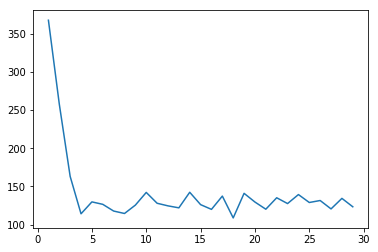

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:144: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)
c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    12.47      2.94602e+07        6          16.1585          86.7587     48.37s
   1     4.91      2.26106e+06        5          14.4126          82.5719     35.94s
   2     5.60      1.72846e+06        5          14.6185          93.3314     33.92s
   3     5.46      2.50084e+06        6          10.8815          132.492     42.08s
   4     2.91           648134        2          10.6007          126.833     33.96s
   5     2.30           333609        2          10.6007          126.833     32.74s
   6     2.28           408138        2          10.6007          126.833     26.05s
   7     2.28           197545        2          10.6392          126.499     25.50s
   8     2.30           536953        2          10.6007          126.833     23.49s
   9     2.29           248177        2          10.6007          126.833     20.60s
  10     2.30           281223        2          10.6007          126.833     16.74s
  11     2.29           628149        2          10.6007         

In [14]:
#Step 4: Symbolic Regression 
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt',  'abs', 'neg', 'inv', xexp]
est_gp = SymbolicRegressor(population_size=5000, generations=20, 
                           stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=5,
                           function_set = f_set)

depth = []
for i in d: 
    depth.append(i)  
print(depth)
depth = np.array([depth])
print(test_error)
for i in range(0,3):
    plt.plot(depth.reshape(-1,1),1000*test_error[i])
    plt.show()
    est_gp.fit(depth.reshape(-1,1), 1000*test_error[i])
    print(est_gp._program)

### Conclusions experiment 2: 

**Theoretical expectations for Empirical Error Estimation:**
<br>Train error curve should decrease until irreducible error (train error goes to zero, which points a possible overfitting).
<br>Test error curve should present U-shape (error decreses and then increases with model capacity.The more capacity the lower the bias; the less the bias the better the ability to fit data well, which increases variance).The U-shape is not oberved in any dataset. Test error decreases as deeper trees are created and then reaches a plateau.
<br>Theoretical bounds do not approximate test_error as well as in the experiments with increasing sample size. The Rademacher Bound follows the behavior of the test error curve, but not always upper bound it. The VC bound is heavily biased towards train error and fails to provide meaningful information. 

**Symbolic Regression Results:**
<br>Symbolic regression failed to find meanigful function to describe relationship between depth and test error for all datasets.


## Experiment 3:  Evaluating how train and test error varies by changing model capacity and sample size at the same time
Empirical train and test error: Missclassification Rate
<br>Theoretical Bounds: Rademacher and VC Bounds for Classification

Hyperparameters: 
<br>Test Samples = 30
<br>Train Samples = [6,8,12...50]
<br>Varying model capacity by tree depth size = [1,2,3...,10]
<br>Run each tree 100 times and take the average for calculating the empirical erros to reduce noise. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn import tree
from sklearn import metrics

n = range(6,52,2)
n_2 = range(0,100,1)
d = range(1,11)
test_error = np.zeros([len(d),len(n)])
train_error = np.zeros([len(d),len(n)])
Rad = np.zeros([len(d),len(n)])
temp = []
temp2= []
temp_train = []
temp2_train = []
temp_L = []
temp_L2 = []

X_test, Y_test = make_moons(n_samples= 30, noise=0.2)

for counter,value in enumerate(n): 
    print("samples", str(value))
    for i in d:
        print("depth", str(i))
        for j in n_2:
            #step 1 - data generation   
            X_train, Y_train = make_moons(n_samples= value, noise=0.2)

            #rademacher sigma
            s = rademacher_variables(len(Y_train))
            
            #step 2 - model training
            
            # Create Decision Tree classifer object
            clf = DecisionTreeClassifier(max_depth= i)

            #inserting train data in model for training
            clf.fit(X_train,Y_train)

            #predicting values for train/test data
            Y_pred_test = clf.predict(X_test)
            Y_pred_train = clf.predict(X_train)

            #computing misclassification rate for train and test
            acc_test = clf.score(X_test, Y_test)
            temp.append(1-acc_test)

            acc_train= clf.score(X_train, Y_train)
            temp_train.append(1-acc_train)

            #Rademacher constant`
            scores = Y_train != Y_pred_train
            L = np.dot(s, scores)/len(Y_train)
            temp_L.append(L)


        temp2.append(sum(temp) / len(temp))
        temp2_train.append(sum(temp_train)/len(temp_train))
        temp_L2.append(max(temp_L))
        temp.clear()
        temp_train.clear()
        temp_L.clear()
    test_error[:,counter] = temp2
    train_error[:,counter] = temp2_train
    Rad[:,counter] = temp_L2
    temp2.clear()
    temp2_train.clear()
    temp_L2.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(len(d), len(n), np.array(n), 0.1, train_error, Rad)
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_classification(len(d), len(n), np.array(n), Rad)
print("VC Dimension")
print(VCdim)
VCBound = VC_bound(len(d), len(n), np.array(n), train_error, VCdim, 0.1)
print("VC Bound")
print(VCBound)

samples 6
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 8
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 10
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 12
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 14
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 16
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 18
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 20
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 22
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 24
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9
depth 10
samples 26
depth 1
depth 2
depth 3
depth 4
depth 5
depth 6
depth 7
depth 8
depth 9

c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
c:\users\gabi\miniconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply


Min Missclassification Rate:  0.10933333333333316
Position of min error:  (array([9], dtype=int64), array([20], dtype=int64))
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]

Min Missclassification Rate for each tree with depth d
[0.19566667 0.12666667 0.129      0.137      0.118      0.11766667
 0.117      0.112      0.116      0.10933333]


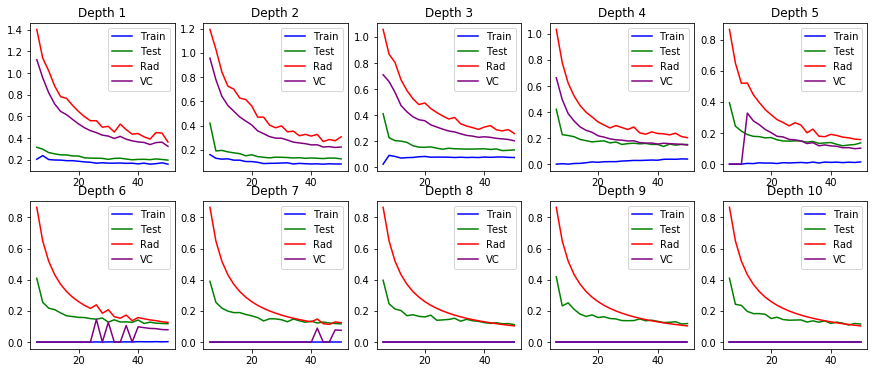

In [18]:
#Step 3: evaluation

import matplotlib.pyplot as plt

print("Min Missclassification Rate: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min error: ', pos)
print(list(d))
print(list(n))

print('\nMin Missclassification Rate for each tree with depth d')
print(np.amin(test_error, axis = 1))

#plotting
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.flatten()
for i in d:
    axs[i-1].plot(n, train_error[i-1,:], color = 'blue', label = 'Train')
    axs[i-1].plot(n, test_error[i-1,:], color = 'green', label = 'Test')
    axs[i-1].plot(n, radBound[i-1], color = 'red', label = 'Rad')
    axs[i-1].plot(n,VCBound[i-1], color = 'purple', label = 'VC')
    axs[i-1].legend(loc='upper right')
    axs[i-1].set_title("Depth %d" %i)
plt.show()


In [39]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=6000, metric = 'rmse',
                           generations=25, stopping_criteria=0.0001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.8, verbose=1,
                           parsimony_coefficient=0.2, random_state=0,
                           function_set = f_set)
depth = []
samples = []
for i in d: 
    depth.append(i)  
for i in n: 
    samples.append(i)  

a = np.transpose([ np.repeat(samples, len(depth)), np.tile(depth, len(samples))])
error = np.array(list(test_error.flatten()))
est_gp.fit(a,1000*error)
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    11.97      4.42351e+08       36          93.2459           112.58      1.11m
   1    10.86       1.6056e+07       23          76.2918          82.7125      1.13m
   2    14.12      1.98076e+08       16          56.6699           84.502      1.19m
   3    18.11      3.58602e+08       24           57.896          72.5022      1.33m
   4    22.15      4.28369e+07       18          52.8637          90.0383      1.45m
   5    22.77      3.92201e+08       22          52.1833          79.5952      1.42m
   6    20.45      4.83332e+08       14           41.945          101.921      1.35m
   7    17.74      3.70593e+08       17          47.6935          97.2126      1.21m
   8    16.42      2.26412e+07       17          49.2211          96.9889      1.16m
   9    15.53       1.7695e+07       10          48.0596          94.6387     58.74s
  10    15.24      1.07436e+07       31          48.4051           90.324     54.11s
  11    14.87      1.17515e+07       14          47.5643         

### Conclusions experiment 3: 
**Empirical Error Estimation Results:**
<br>Once tree achieves depth 5 there is no much improvement in the missclassification rate (~11%) for  deeper trees. When the capacity is small (depth 1,2 and 3), train and test curves show similar behavior as in the experiments in 1 (varying only sample size).
<br>Rademacher bounds seems to be more robust againts the effect of train error going to zero, but it is loose when compared to the test error (mainly for small sample size). VC Bound is completely biased towards the effect of train error ~ 0 and therefore, does not provide meaningful information. 

**Symbolic Regression Results:**
<br>Symbolic regression fails to find a meaningful function for this experiment. 